In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer
import math

In [2]:
df = pd.read_csv('cleaned_extracted_data.csv').drop(["HINPOVA","INHPE"], axis = 1)

In [3]:
continuous_features = ['BMI', 'INHPFN',  'HHHRES', 'HCHILD','LIVSIB',  'HAIRA', 'HATOTB', 'IEARN','HITOT', 'PRPCNT']
cate_features = ['HINPOV','PENINC', 'HIGOV', 'RETMON', 'SLFEMP']

In [4]:
grouped_df = df.groupby(cate_features).size().reset_index(name='Count')

In [26]:
filtered_df = pd.DataFrame()

for name, group in df.groupby(cate_features):
    isol_forest = IsolationForest(random_state=42, n_estimators=500 ,n_jobs=-1)
    outliers = isol_forest.fit_predict(group)

    filtered_group = group[outliers == 1]

    filtered_df = pd.concat([filtered_df, filtered_group], ignore_index=True)
    
filtered_df.groupby(cate_features).size().reset_index(name='Count').sort_values("Count", ascending = False)

,HINPOV,PENINC,HIGOV,RETMON,SLFEMP,Count
0,0.0,0.0,0.0,0,0.0,11981
4,0.0,0.0,1.0,0,0.0,4578
6,0.0,0.0,1.0,1,0.0,4122
7,0.0,0.0,1.0,1,1.0,2983
14,0.0,1.0,1.0,1,0.0,2705
5,0.0,0.0,1.0,0,1.0,2563
1,0.0,0.0,0.0,0,1.0,1981
15,0.0,1.0,1.0,1,1.0,1422
12,0.0,1.0,1.0,0,0.0,896
16,1.0,0.0,0.0,0,0.0,596


In [30]:
filtered_df.to_csv("Removed_outliers_byGroup_data.csv", index=False)

In [5]:
def kf_RandomForestRegressor(X, y, n_estimators =100 ,k=5):
    # Set up k-fold parameters
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    #Store the results of each validation
    train_r_squared = []
    test_r_squared = []
    train_mse = []
    test_mse = []
    
    importance = np.zeros(10)

    # Iterate through the cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # set up the RF model
        model = RandomForestRegressor(n_estimators = n_estimators, n_jobs=-1).fit(X_train, y_train)
        
        # Predict and calculate performance and errors
        train_pred = model.predict(X_train)        
        train_r_squared.append(r2_score(y_train, train_pred))
        train_mse.append(mean_squared_error(y_train, train_pred))
        
        test_pred = model.predict(X_test)
        test_r_squared.append(r2_score(y_test, test_pred))
        test_mse.append(mean_squared_error(y_test, test_pred))
        
        importance = importance + model.feature_importances_
        
    print(f"Train: R-squared = {np.mean(train_r_squared)}, MSE = {np.mean(train_mse)}\nTest: R-squared = {np.mean(test_r_squared)}, MSE = {np.mean(test_mse)}")
    return (importance/5)

In [12]:
target_features = ['SHLT', 'COGTOT', 'MSTOT']

# Filter groups with count > 100
filtered_groups = grouped_df[grouped_df['Count'] > 500]

# Initialize a dictionary to hold the results
group_importance_results = {}   

# Iterate over each group
for index, row in filtered_groups.iterrows():
    # Get the combination of categorical features for the group
    cat_combination = tuple(row[cate_features])
    
    # Filter the original df for the group's data
    group_data = df[(df[cate_features[0]] == row[cate_features[0]]) &
                    (df[cate_features[1]] == row[cate_features[1]]) &
                    (df[cate_features[2]] == row[cate_features[2]]) &
                    (df[cate_features[3]] == row[cate_features[3]]) &
                    (df[cate_features[4]] == row[cate_features[4]])
                    ]
    
    # Split into X and y
    X = group_data[continuous_features].values
    y = group_data[target_features].values
    
    # Flatten y if you are running for a single target feature at a time
    # y = y.ravel()  # Do this if kf_RandomForestRegressor expects a 1D array for y
    
    # Run the kf_RandomForestRegressor function
    feature_importance = kf_RandomForestRegressor(X, y, 100, 10)
    
    # Store the feature importance with the group's categorical combination
    group_importance_results[cat_combination] = feature_importance

# Output the results
for cat_combination, importance in group_importance_results.items():
    print(f"Category Combination: {cat_combination}, Feature Importance: {importance}")


Train: R-squared = 0.966092328106727, MSE = 0.2298919986052217
Test: R-squared = 0.7539694108606672, MSE = 1.6937560160355243
Train: R-squared = 0.9623173670542456, MSE = 0.24312778311965838
Test: R-squared = 0.7290956324951536, MSE = 1.7419661217948719
Train: R-squared = 0.9670972617211888, MSE = 0.25689217326520425
Test: R-squared = 0.7729038709486785, MSE = 1.7924407460925067
Train: R-squared = 0.9669610699114177, MSE = 0.2584166924250556
Test: R-squared = 0.7614359682842938, MSE = 1.8730949815512958
Train: R-squared = 0.9661411767355137, MSE = 0.23397866546561538
Test: R-squared = 0.7600476020547067, MSE = 1.6523332065752157
Train: R-squared = 0.9645603612700742, MSE = 0.255391391656055
Test: R-squared = 0.72271340399882, MSE = 1.9738274427117433
Train: R-squared = 0.9616630656521348, MSE = 0.2663325326448501
Test: R-squared = 0.7053449585027518, MSE = 2.00183559128702
Train: R-squared = 0.9654075924344891, MSE = 0.2448125430453772
Test: R-squared = 0.7546334511847842, MSE = 1.5519

In [10]:
'https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html'

'https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html'

In [38]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def kf_RandomForestRegressor(X, y, continuous_features, n_estimators=100, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    train_r_squared = []
    test_r_squared = []
    train_mse = []
    test_mse = []
    importance = np.zeros(len(continuous_features))  # Adjusted to the number of continuous features

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1)
        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        train_r_squared.append(r2_score(y_train, train_pred))
        train_mse.append(mean_squared_error(y_train, train_pred))
        test_r_squared.append(r2_score(y_test, test_pred))
        test_mse.append(mean_squared_error(y_test, test_pred))

        importance += model.feature_importances_

    avg_importance = importance / k
    print(f"Train: R-squared = {np.mean(train_r_squared)}, MSE = {np.mean(train_mse)}")
    print(f"Test: R-squared = {np.mean(test_r_squared)}, MSE = {np.mean(test_mse)}")
    
    return avg_importance



Processing for target feature: SHLT
Train: R-squared = 0.9558666841835315, MSE = 0.043002075119859796
Test: R-squared = 0.6881953418914658, MSE = 0.30372406348901687
Group (0.0, 0.0, 0.0, 0.0, 0.0)
Train: R-squared = 0.9529205491293897, MSE = 0.04524752403846153
Test: R-squared = 0.6454657259238351, MSE = 0.3415665865384615
Group (0.0, 0.0, 0.0, 0.0, 1.0)
Train: R-squared = 0.9583158427972454, MSE = 0.03817576055720495
Test: R-squared = 0.7236444388936777, MSE = 0.25290062443679556
Group (0.0, 0.0, 1.0, 0.0, 0.0)
Train: R-squared = 0.9586657727243875, MSE = 0.03973903950637371
Test: R-squared = 0.6856915650869743, MSE = 0.3024917515579338
Group (0.0, 0.0, 1.0, 0.0, 1.0)
Train: R-squared = 0.9558978799368951, MSE = 0.03792949566244826
Test: R-squared = 0.6809642222202121, MSE = 0.2739773338944791
Group (0.0, 0.0, 1.0, 1.0, 0.0)
Train: R-squared = 0.9544260976091461, MSE = 0.04227528423932901
Test: R-squared = 0.6498248926467018, MSE = 0.32457105749517157
Group (0.0, 0.0, 1.0, 1.0, 1.0)


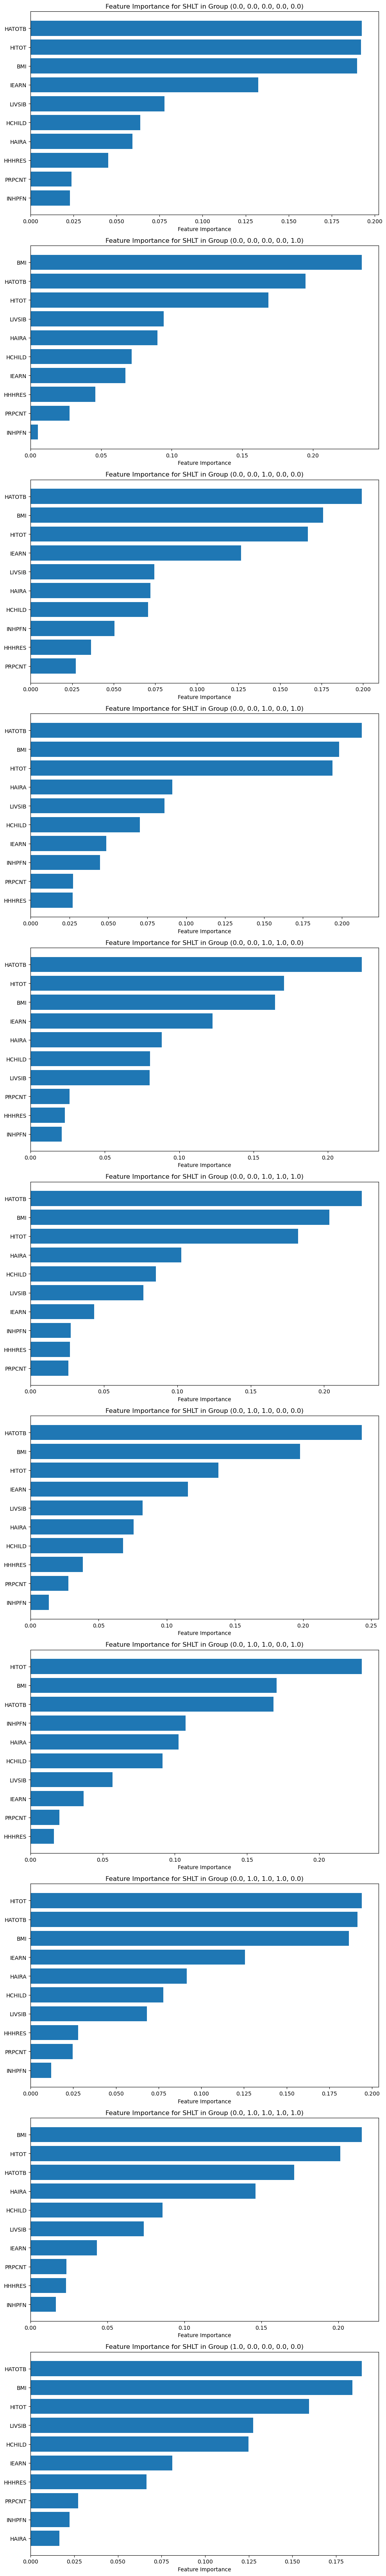

Processing for target feature: COGTOT
Train: R-squared = 0.9557866720162058, MSE = 0.7003612469670498
Test: R-squared = 0.6803541902215464, MSE = 5.059854101973913
Group (0.0, 0.0, 0.0, 0.0, 0.0)
Train: R-squared = 0.9515407841833431, MSE = 0.7413937620192307
Test: R-squared = 0.6432563873996555, MSE = 5.434877163461539
Group (0.0, 0.0, 0.0, 0.0, 1.0)
Train: R-squared = 0.9564080709638031, MSE = 0.8071604232112468
Test: R-squared = 0.7004688947180286, MSE = 5.553009569885893
Group (0.0, 0.0, 1.0, 0.0, 0.0)
Train: R-squared = 0.9558922711223425, MSE = 0.8409115800755542
Test: R-squared = 0.6694576762518408, MSE = 6.306946140327466
Group (0.0, 0.0, 1.0, 0.0, 1.0)
Train: R-squared = 0.957853093374743, MSE = 0.7152006114813874
Test: R-squared = 0.6981840033305657, MSE = 5.118667467472676
Group (0.0, 0.0, 1.0, 1.0, 0.0)
Train: R-squared = 0.9542331094667184, MSE = 0.7910414013909614
Test: R-squared = 0.6334024669265508, MSE = 6.3539324770960235
Group (0.0, 0.0, 1.0, 1.0, 1.0)
Train: R-squar

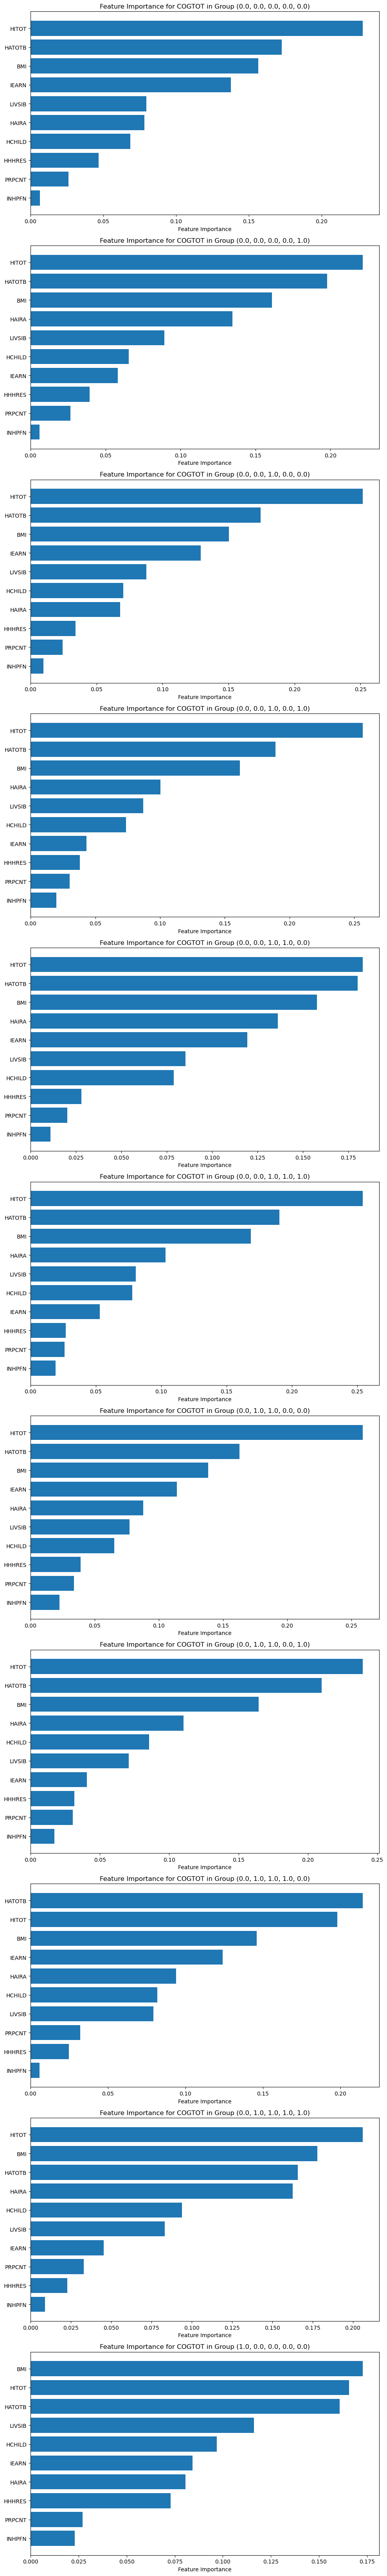

Processing for target feature: MSTOT
Train: R-squared = 0.954973584691104, MSE = 0.1532332116628748
Test: R-squared = 0.680764812045785, MSE = 1.0848495793302675
Group (0.0, 0.0, 0.0, 0.0, 0.0)
Train: R-squared = 0.949118676588402, MSE = 0.15985618990384615
Test: R-squared = 0.6346337817720108, MSE = 1.1441719230769232
Group (0.0, 0.0, 0.0, 0.0, 1.0)
Train: R-squared = 0.9553412199464277, MSE = 0.17270375592613765
Test: R-squared = 0.7042910049363705, MSE = 1.144898561509842
Group (0.0, 0.0, 1.0, 0.0, 0.0)
Train: R-squared = 0.9571576123044752, MSE = 0.137342178993765
Test: R-squared = 0.6543446380491114, MSE = 1.1100432274916934
Group (0.0, 0.0, 1.0, 0.0, 1.0)
Train: R-squared = 0.9540284451847956, MSE = 0.15699004261733787
Test: R-squared = 0.6756502371767037, MSE = 1.109227363176085
Group (0.0, 0.0, 1.0, 1.0, 0.0)
Train: R-squared = 0.953212029532593, MSE = 0.14786396209894767
Test: R-squared = 0.6062089030068872, MSE = 1.248355982271084
Group (0.0, 0.0, 1.0, 1.0, 1.0)
Train: R-squa

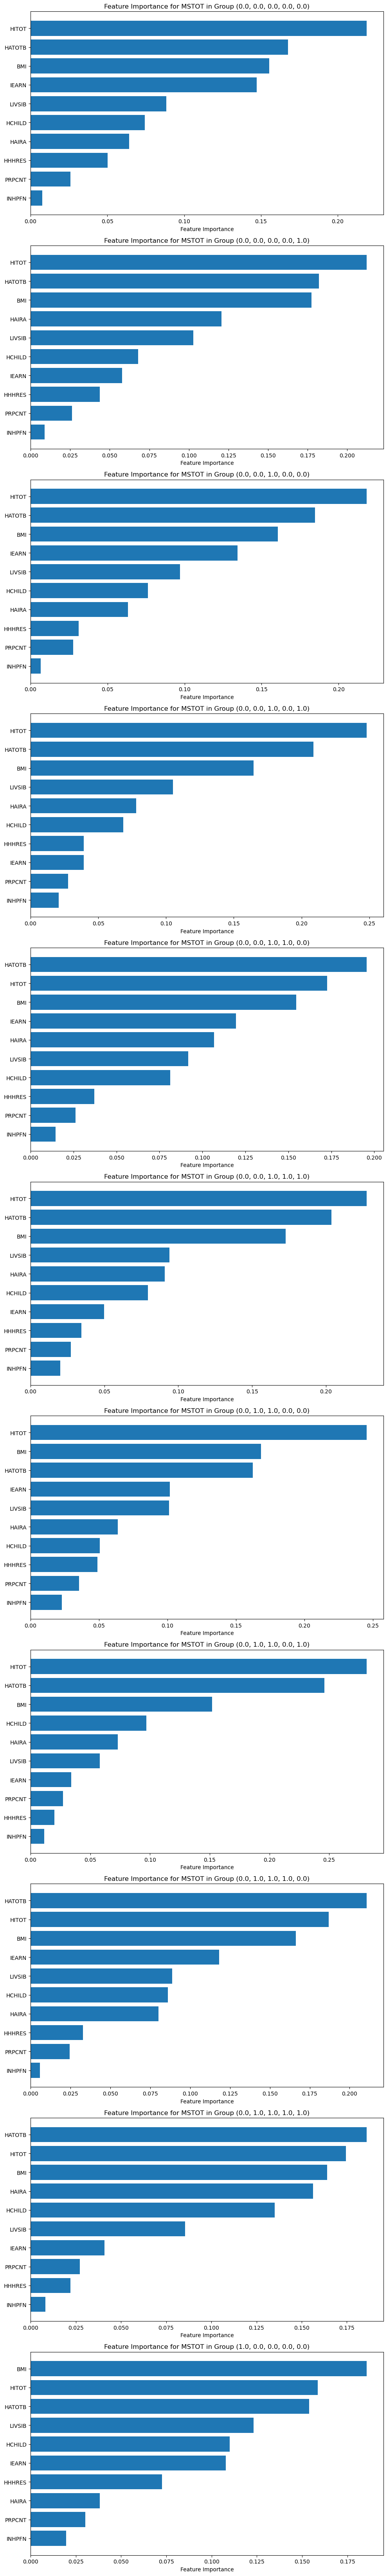

In [46]:
# Filter groups with count > 100
filtered_groups = grouped_df[grouped_df['Count'] > 500]

# Iterate over each target feature
for target in target_features:
    print(f"Processing for target feature: {target}")
    
    # Dictionary to hold the results for this target feature
    group_importance_results[target] = {}

    # Prepare the figure for the current target feature
    n_groups = filtered_groups.shape[0]
    fig, axes = plt.subplots(n_groups, 1, figsize=(10, 6 * n_groups))
    if n_groups == 1:
        axes = [axes]  # Make it iterable for a single subplot

    # Iterate over each group and axis
    for (index, row), ax in zip(filtered_groups.iterrows(), axes):
        cat_combination = tuple(row[cate_features])
        group_data = df[(df[cate_features] == row[cate_features].values).all(axis=1)]
        
        X = group_data[continuous_features].values
        y = group_data[target].values  # Using one target feature at a time
        
        # Run the kf_RandomForestRegressor function
        feature_importance = kf_RandomForestRegressor(X, y, continuous_features)

        # Store the feature importance with the group's categorical combination
        group_importance_results[target][cat_combination] = feature_importance

        # Plot the feature importance for the current group and target feature
        sorted_idx = np.argsort(feature_importance)
        ax.barh(np.array(continuous_features)[sorted_idx], feature_importance[sorted_idx])
        ax.set_title(f'Feature Importance for {target} in Group {cat_combination}')
        ax.set_xlabel('Feature Importance')

        print(f"Group {cat_combination}")

    # Adjust layout and show the figure for the current target feature
    plt.tight_layout()
    plt.show()


In [4]:
df = pd.read_csv("Removed_outliers_byGroup_data.csv")
X = df.drop(['SHLT', 'COGTOT', 'MSTOT'], axis = 1).values
y = df[['SHLT', 'COGTOT', 'MSTOT']].values

In [ ]:
def kf_RandomForestRegressor(X, y, n_estimators =100 ,k=5):
    # Set up k-fold parameters
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    #Store the results of each validation
    train_r_squared = []
    test_r_squared = []
    train_mse = []
    test_mse = []
    
    importance = np.zeros(10)
    
    # Iterate through the cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # set up the RF model
        model = RandomForestRegressor(n_estimators = n_estimators, n_jobs=-1).fit(X_train, y_train)
        
        # Predict and calculate performance and errors
        train_pred = model.predict(X_train)        
        train_r_squared.append(r2_score(y_train, train_pred))
        train_mse.append(mean_squared_error(y_train, train_pred))
        
        test_pred = model.predict(X_test)
        test_r_squared.append(r2_score(y_test, test_pred))
        test_mse.append(mean_squared_error(y_test, test_pred))
        
        importance = importance + model.feature_importances_
        
    print(f"Train: R-squared = {np.mean(train_r_squared)}, MSE = {np.mean(train_mse)}\nTest: R-squared = {np.mean(test_r_squared)}, MSE = {np.mean(test_mse)}")
    return (importance/5)